# GAN - Generative Adversarial Networks

### Generate new samples similar to the data they were trained on

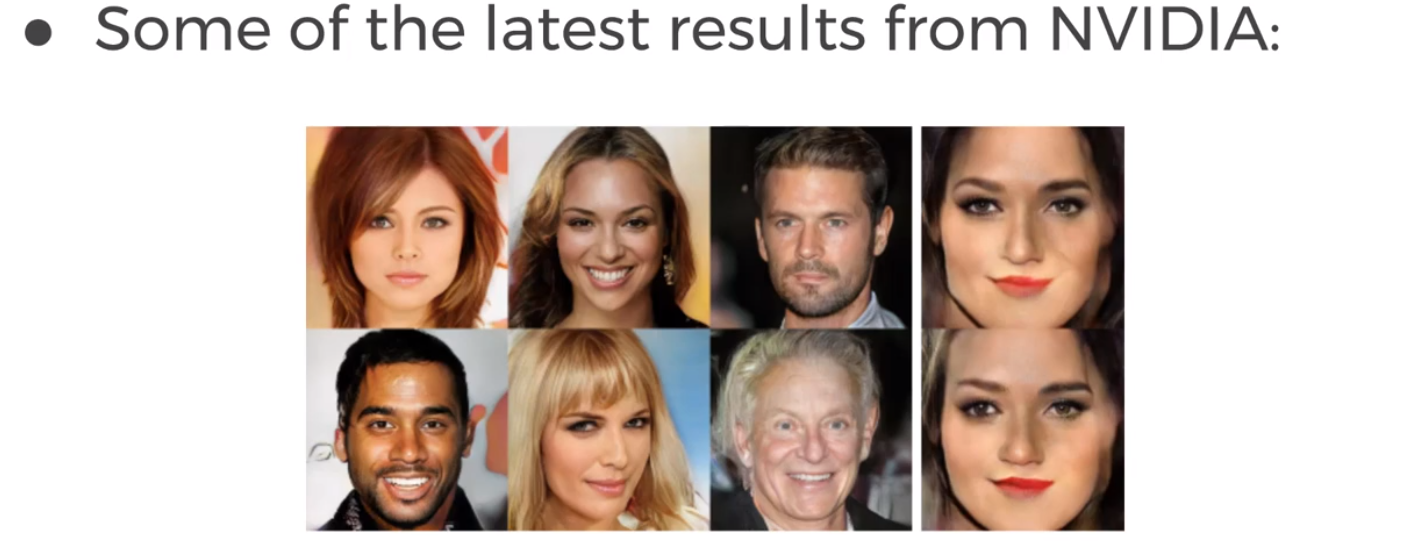

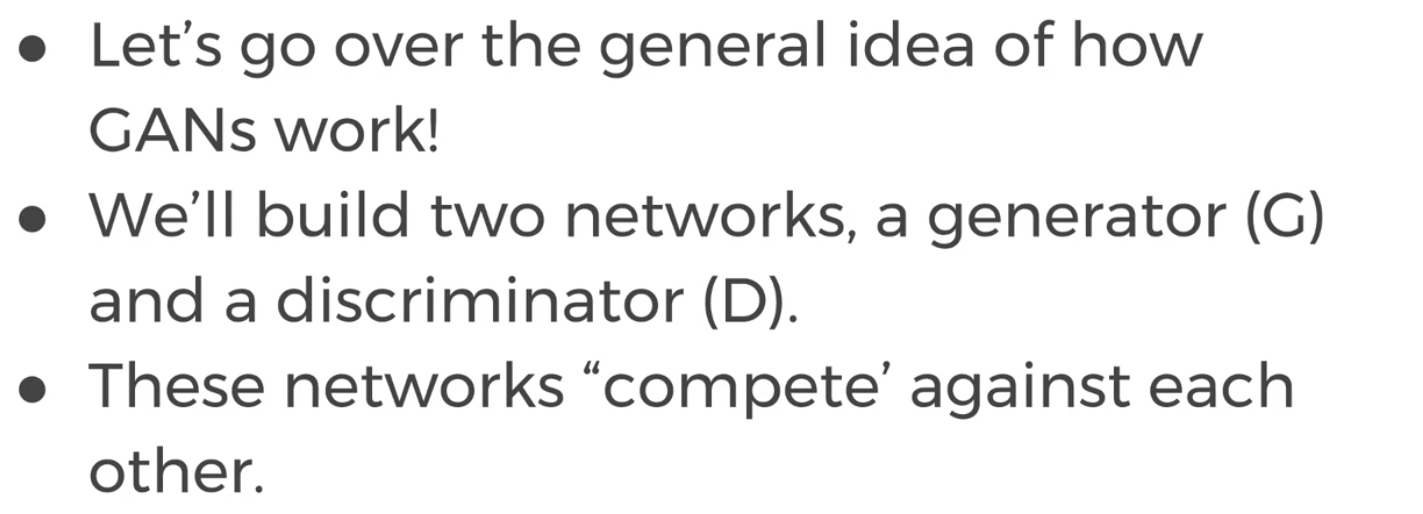

### Forger (Generator) Vs Detective (Discriminator)  

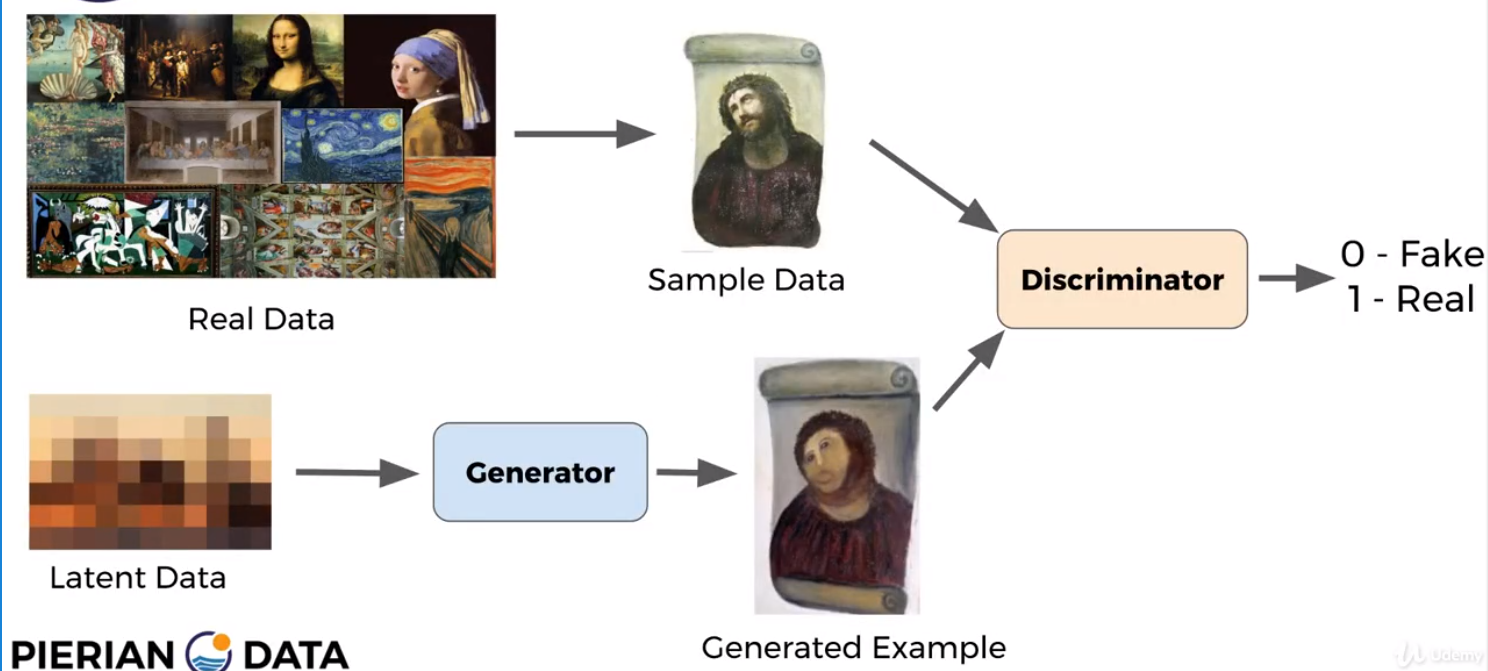

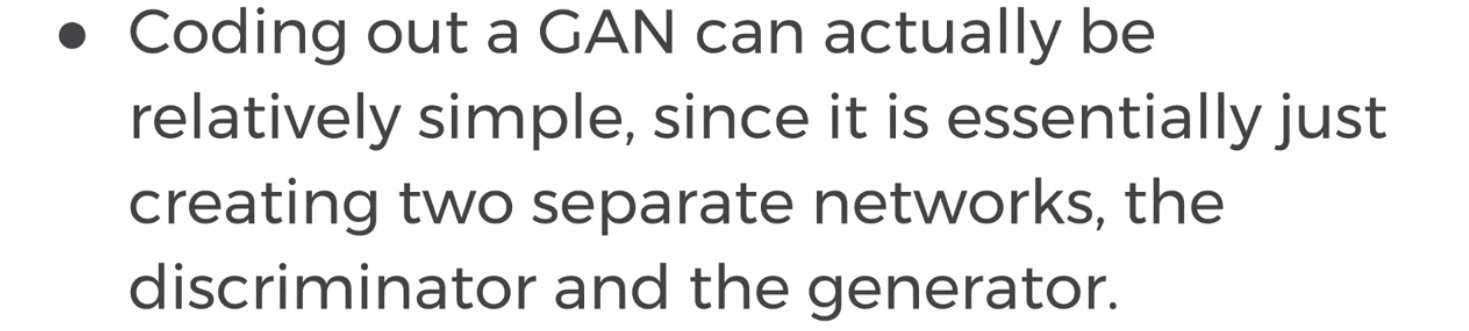

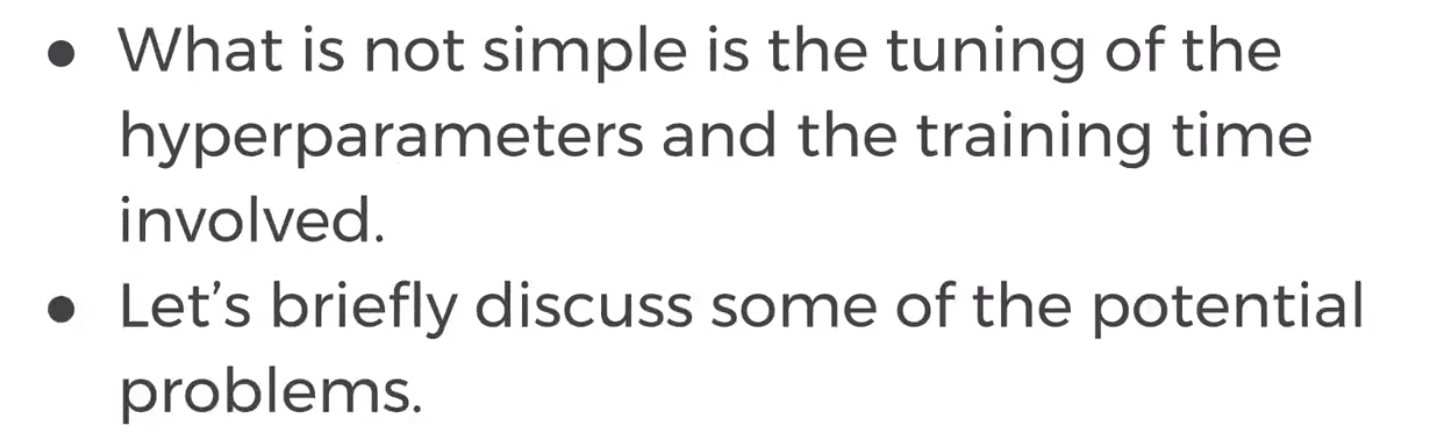

# Generating New Numbers Using MNIST Dataset

In [1]:
import tensorflow as tf

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

In [4]:
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
# pick an nth image

n = 133

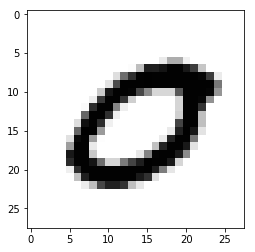

In [6]:
plt.imshow(mnist.train.images[n].reshape(28,28),cmap="Greys")

In [7]:
decoded = tf.argmax(mnist.train.labels[n])

with tf.Session() as sess:
    print(sess.run(decoded))

0


# Building Generator Network

In [8]:
tf.reset_default_graph()

In [9]:
def generator(z, reuse=None):
    with tf.variable_scope("gen",reuse=reuse):
        hidden1 = tf.layers.dense(inputs=z,units=128)
        
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1, hidden1) # activation function leakyrelu
        
        hidden2 = tf.layers.dense(inputs=hidden1, units = 128)
        
        hidden2 = tf.maximum(alpha*hidden2, hidden2) # activation function leakyrelu
        
        output = tf.layers.dense(hidden2,units=784,activation=tf.nn.tanh)
        
        return output

In [10]:
def discriminator(X, reuse=None):
    with tf.variable_scope("dis",reuse=reuse):
        hidden1 = tf.layers.dense(inputs=X,units=128)
        
        alpha = 0.01
        hidden1 = tf.maximum(alpha*hidden1, hidden1)
        
        hidden2 = tf.layers.dense(inputs=hidden1, units=128)
        
        hidden2 = tf.maximum(alpha*hidden2, hidden2)
        
        logits = tf.layers.dense(hidden2, units=1)
        output = tf.sigmoid(logits)
        
        return output, logits

In [11]:
real_images = tf.placeholder(tf.float32, shape=[None,784])
z = tf.placeholder(tf.float32, shape=[None,100]) # Feed generator 100 random points

In [12]:
G = generator(z)

In [13]:
D_output_real, D_logits_real = discriminator(real_images)

In [14]:
D_output_fake, D_logits_fake = discriminator(G, reuse=True)

## Losses

In [15]:
def loss_func(logits_in, labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=logits_in, labels=labels_in))

In [16]:
# multiply by 0.9 for smoothin
D_real_loss = loss_func(D_logits_real, tf.ones_like(D_logits_real)*0.9)
D_fake_loss = loss_func(D_logits_fake, tf.zeros_like(D_logits_fake))

In [17]:
D_loss = D_real_loss + D_fake_loss

In [18]:
G_loss = loss_func(D_logits_fake,tf.ones_like(D_logits_fake))

In [19]:
learning_rate = 0.001

In [20]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

In [21]:
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss,var_list=d_vars)

In [22]:
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

In [23]:
d_vars

[<tf.Variable 'dis/dense/kernel:0' shape=(784, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/kernel:0' shape=(128, 1) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/bias:0' shape=(1,) dtype=float32_ref>]

In [24]:
g_vars

[<tf.Variable 'gen/dense/kernel:0' shape=(100, 128) dtype=float32_ref>,
 <tf.Variable 'gen/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'gen/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'gen/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'gen/dense_2/kernel:0' shape=(128, 784) dtype=float32_ref>,
 <tf.Variable 'gen/dense_2/bias:0' shape=(784,) dtype=float32_ref>]

In [25]:
batch_size = 100

In [26]:
epochs = 200

In [27]:
init = tf.global_variables_initializer()

In [28]:
samples = []

In [29]:
with tf.Session() as sess:
    
    sess.run(init)
    
    for epoch in range(epochs):
        
        num_batches = mnist.train.num_examples // batch_size
        
        for i in range(num_batches):
            
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size,784))
            batch_images = batch_images * 2 - 1
            
            batch_z = np.random.uniform(-1,1,size=(batch_size,100))
            
            _ = sess.run(D_trainer,feed_dict={real_images:batch_images, z:batch_z})
            _ = sess.run(G_trainer, feed_dict={z:batch_z})
            
        print("ON EPOCH {}".format(epoch))
        
        sample_z = np.random.uniform(-1,1,size=(1,100))
        gen_sample = sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        
        samples.append(gen_sample)

ON EPOCH 0
ON EPOCH 1
ON EPOCH 2
ON EPOCH 3
ON EPOCH 4
ON EPOCH 5
ON EPOCH 6
ON EPOCH 7
ON EPOCH 8
ON EPOCH 9
ON EPOCH 10
ON EPOCH 11
ON EPOCH 12
ON EPOCH 13
ON EPOCH 14
ON EPOCH 15
ON EPOCH 16
ON EPOCH 17
ON EPOCH 18
ON EPOCH 19
ON EPOCH 20
ON EPOCH 21
ON EPOCH 22
ON EPOCH 23
ON EPOCH 24
ON EPOCH 25
ON EPOCH 26
ON EPOCH 27
ON EPOCH 28
ON EPOCH 29
ON EPOCH 30
ON EPOCH 31
ON EPOCH 32
ON EPOCH 33
ON EPOCH 34
ON EPOCH 35
ON EPOCH 36
ON EPOCH 37
ON EPOCH 38
ON EPOCH 39
ON EPOCH 40
ON EPOCH 41
ON EPOCH 42
ON EPOCH 43
ON EPOCH 44
ON EPOCH 45
ON EPOCH 46
ON EPOCH 47
ON EPOCH 48
ON EPOCH 49
ON EPOCH 50
ON EPOCH 51
ON EPOCH 52
ON EPOCH 53
ON EPOCH 54
ON EPOCH 55
ON EPOCH 56
ON EPOCH 57
ON EPOCH 58
ON EPOCH 59
ON EPOCH 60
ON EPOCH 61
ON EPOCH 62
ON EPOCH 63
ON EPOCH 64
ON EPOCH 65
ON EPOCH 66
ON EPOCH 67
ON EPOCH 68
ON EPOCH 69
ON EPOCH 70
ON EPOCH 71
ON EPOCH 72
ON EPOCH 73
ON EPOCH 74
ON EPOCH 75
ON EPOCH 76
ON EPOCH 77
ON EPOCH 78
ON EPOCH 79
ON EPOCH 80
ON EPOCH 81
ON EPOCH 82
ON EPOCH 83
ON

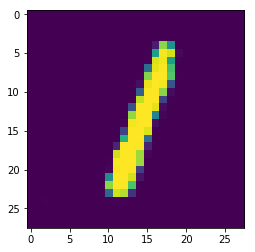

In [77]:
plt.imshow(samples[195].reshape(28,28))

In [31]:
saver = tf.train.Saver(var_list = g_vars)

In [32]:
new_samples = []
with tf.Session() as sess:
    
    saver.restore(sess, "./06-Generative-Adversarial-Networks/models/500_epoch_model.ckpt")
    
    for x in range(10):
        samples_z = np.random.uniform(-1,1,size=(1,100))
        gen_sample = sess.run(generator(z,reuse=True),feed_dict={z:sample_z})
        
        new_samples.append(gen_sample)

INFO:tensorflow:Restoring parameters from ./06-Generative-Adversarial-Networks/models/500_epoch_model.ckpt


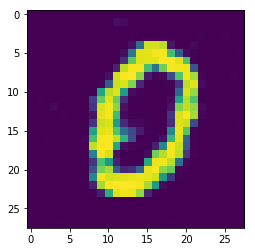

In [33]:
plt.imshow(new_samples[3].reshape(28,28))

In [40]:
a = [1,2,3,4,5]

In [42]:
a[0:2]

[1, 2]